<a href="https://colab.research.google.com/github/koopatroopa787/Google-colab/blob/main/transformers(self_build)%5B2_9M_param_%26_141M_param%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# PyTorch for implementing LLM (GPU)
import torch

# Neural network modules and functions from PyTorch
from torch import nn
from torch.nn import functional as F

# NumPy for numerical operations
import numpy as np

# Matplotlib for plotting Loss etc.
from matplotlib import pyplot as plt

# Time module for tracking execution time
import time

# Pandas for data manipulation and analysis
import pandas as pd

# urllib for handling URL requests (Downloading Dataset)
import urllib.request


In [ ]:
# Configuration object for model parameters
MASTER_CONFIG = {
    # Adding parameters later
}

In [ ]:
# The URL of the raw text file on GitHub
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"

# The file name for local storage
file_name = "tinyshakespeare.txt"

# Execute the download
urllib.request.urlretrieve(url, file_name)

('tinyshakespeare.txt', <http.client.HTTPMessage at 0x7ea12839fd90>)

In [ ]:
# Read the content of the dataset
lines = open("tinyshakespeare.txt", 'r').read()

# Create a sorted list of unique characters in the dataset
vocab = sorted(list(set(lines)))

# Display the first 10 characters in the vocabulary list
print('Printing the first 10 characters of the vocab list:', vocab[:10])

# Output the total number of characters in our dataset (Vocabulary Size)
print('Total number of characters in our dataset (Vocabulary Size):', len(vocab))

Printing the first 10 characters of the vocab list: ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3']
Total number of characters in our dataset (Vocabulary Size): 65


In [ ]:
# Mapping integers to characters (itos)
itos = {i: ch for i, ch in enumerate(vocab)}

# Mapping characters to integers (stoi)
stoi = {ch: i for i, ch in enumerate(vocab)}

In [ ]:
# Encode function: Converts a string to a list of integers using the mapping stoi
def encode(s):
    return [stoi[ch] for ch in s]

# Decode function: Converts a list of integers back to a string using the mapping itos
def decode(l):
    return ''.join([itos[i] for i in l])

# Example: Encode the string "hello" and then decode the result
decode(encode("morning"))

'morning'

In [ ]:
# Convert the dataset into a torch tensor with specified data type (dtype)
dataset = torch.tensor(encode(lines), dtype=torch.int8)

# Display the shape of the resulting tensor
print(dataset.shape)

torch.Size([1115394])


In [ ]:
# Function to get batches for training, validation, or testing
def get_batches(data, split, batch_size, context_window, config=MASTER_CONFIG):
    # Split the dataset into training, validation, and test sets
    train = data[:int(.8 * len(data))]
    val = data[int(.8 * len(data)): int(.9 * len(data))]
    test = data[int(.9 * len(data)):]

    # Determine which split to use
    batch_data = train
    if split == 'val':
        batch_data = val
    if split == 'test':
        batch_data = test

    # Pick random starting points within the data
    ix = torch.randint(0, batch_data.size(0) - context_window - 1, (batch_size,))

    # Create input sequences (x) and corresponding target sequences (y)
    x = torch.stack([batch_data[i:i+context_window] for i in ix]).long()
    y = torch.stack([batch_data[i+1:i+context_window+1] for i in ix]).long()

    return x, y

In [ ]:
# Update the MASTER_CONFIG with batch_size and context_window parameters
MASTER_CONFIG.update({
    'batch_size': 8,          # Number of batches to be processed at each random split
    'context_window': 16      # Number of characters in each input (x) and target (y) sequence of each batch
})

In [ ]:
# Obtain batches for training using the specified batch size and context window
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

# Decode the sequences to obtain the corresponding text representations
decoded_samples = [(decode(xs[i].tolist()), decode(ys[i].tolist())) for i in range(len(xs))]

# Print the random sample
print(decoded_samples)

[('\nMadam, we did: ', 'Madam, we did: h'), ('hows me where th', 'ows me where tho'), ('ind me here:\nMy ', 'nd me here:\nMy l'), (' my kin,\nI shoul', 'my kin,\nI should'), ('nce and people: ', 'ce and people: t'), ('IV:\nWhat fates i', 'V:\nWhat fates im'), ('most intelligenc', 'ost intelligenci'), ('oble Marcius!\n\nF', 'ble Marcius!\n\nFi')]


In [ ]:
@torch.no_grad()  # Don't compute gradients for this function
def evaluate_loss(model, config=MASTER_CONFIG):
    # Placeholder for the evaluation results
    out = {}

    # Set the model to evaluation mode
    model.eval()

    # Iterate through training and validation splits
    for split in ["train", "val"]:
        # Placeholder for individual losses
        losses = []

        # Generate 10 batches for evaluation
        for _ in range(10):
            # Get input sequences (xb) and target sequences (yb)
            xb, yb = get_batches(dataset, split, config['batch_size'], config['context_window'])

            # Move inputs and targets to the same device as the model
            xb, yb = xb.to(config['device']), yb.to(config['device'])

            # Perform model inference and calculate the loss
            _, loss = model(xb, yb)

            # Append the loss to the list
            losses.append(loss.item())

        # Calculate the mean loss for the split and store it in the output dictionary
        out[split] = np.mean(losses)

    # Set the model back to training mode
    model.train()

    return out


In [ ]:
class SimpleBrokenModel(nn.Module):
    def __init__(self, config=MASTER_CONFIG):
        super().__init__()
        self.config = config

        # Embedding layer to convert character indices to vectors (vocab size: 65)
        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])

        # Linear layers for modeling relationships between features
        # (to be updated with SwiGLU activation function as in LLaMA)
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),  # Currently using ReLU, will be replaced with SwiGLU as in LLaMA
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        # Device attribute for model
        self.device = config['device']

        # Print the total number of model parameters
        print("Model parameters:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        # Embedding layer converts character indices to vectors
        x = self.embedding(idx)

        # Linear layers for modeling relationships between features

        # Apply softmax activation to obtain a probability distribution
        logits = self.linear(x)

        # If targets are provided, calculate and return the cross-entropy loss
        if targets is not None:
            # Reshape logits and targets for cross-entropy calculation
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        # If targets are not provided, return the logits
        else:
            return logits


In [ ]:
# Update the MASTER_CONFIG with GPU-related parameters
MASTER_CONFIG.update({
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),  # Set the device to GPU if available
    'd_model': 128,
    'vocab_size': 65,
})

# Instantiate the SimpleBrokenModel using the updated MASTER_CONFIG
model = SimpleBrokenModel(MASTER_CONFIG)

# Move the model to the GPU
model.to(MASTER_CONFIG['device'])

# Print the total number of parameters in the model
print("Total number of parameters in the Simple Neural Network Model:", sum([m.numel() for m in model.parameters()]))

Model parameters: 33217
Total number of parameters in the Simple Neural Network Model: 33217


In [ ]:
# Obtain batches for training using the specified batch size and context window
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

# Move the data to the GPU
xs, ys = xs.to(MASTER_CONFIG['device']), ys.to(MASTER_CONFIG['device'])

# Calculate logits and loss using the model
logits, loss = model(xs, ys)

In [ ]:
# Update MASTER_CONFIG with training parameters
MASTER_CONFIG.update({
    'epochs': 1000,          # Number of training epochs
    'log_interval': 10,      # Log information every 10 batches during training
    'batch_size': 32,        # Increase batch size to 32
})

# Instantiate the SimpleBrokenModel with updated configuration
model = SimpleBrokenModel(MASTER_CONFIG)

# Define the Adam optimizer for model parameters
optimizer = torch.optim.Adam(
    model.parameters(),      # Pass the model parameters to the optimizer
)


Model parameters: 33217


In [ ]:
def train(model, optimizer, scheduler=None, config=MASTER_CONFIG, print_logs=False):
    # Placeholder for storing losses
    losses = []

    # Start tracking time
    start_time = time.time()

    # Move the model to the appropriate device
    model.to(model.device)

    # Iterate through epochs
    for epoch in range(config['epochs']):
        # Zero out gradients
        optimizer.zero_grad()

        # Obtain batches for training
        xs, ys = get_batches(dataset, 'train', config['batch_size'], config['context_window'])

        # Move inputs and targets to the same device as the model
        xs, ys = xs.to(model.device), ys.to(model.device)

        # Forward pass through the model to calculate logits and loss
        logits, loss = model(xs, targets=ys)

        # Backward pass and optimization step
        loss.backward()
        optimizer.step()

        # If a learning rate scheduler is provided, adjust the learning rate
        if scheduler:
            scheduler.step()

        # Log progress every specified interval
        if epoch % config['log_interval'] == 0:
            # Calculate batch time
            batch_time = time.time() - start_time

            # Evaluate loss on validation set
            x = evaluate_loss(model)

            # Store the validation loss
            losses += [x]

            # Print progress logs if specified
            if print_logs:
                print(f"Epoch {epoch} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds {batch_time * (config['epochs'] - epoch)/config['log_interval'] :.3f}")

            # Reset the timer
            start_time = time.time()

            # Print learning rate if a scheduler is provided
            if scheduler:
                print("lr: ", scheduler.get_lr())

    # Print the final validation loss
    print("Validation loss: ", losses[-1]['val'])

    # Plot the training and validation loss curves
    return pd.DataFrame(losses).plot()

Model parameters: 33217
Validation loss:  2.5319258689880373


<Axes: >

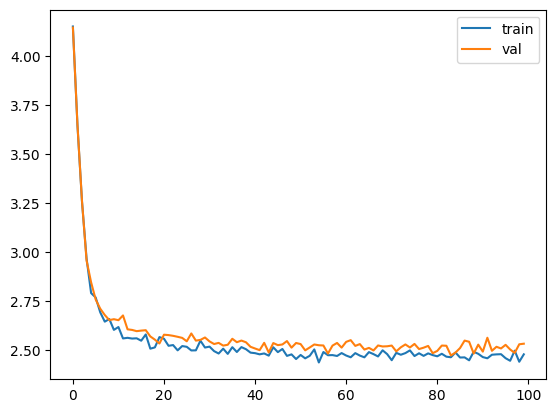

In [ ]:
# Create the updated SimpleModel
model = SimpleBrokenModel(MASTER_CONFIG)

# Obtain batches for training
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

# Calculate logits and loss using the model
logits, loss = model(xs, ys)

# Define the Adam optimizer for model parameters
optimizer = torch.optim.Adam(model.parameters())

# Move the model to the GPU
model.to(MASTER_CONFIG['device'])

# Train the model for 100 epochs
train(model, optimizer)

In [ ]:
def generate(model, config=MASTER_CONFIG, max_new_tokens=30):
    idx = torch.zeros(5, 1).long().to(config['device'])  # Move to GPU
    for _ in range(max_new_tokens):
        # Call the model
        logits = model(idx[:, -config['context_window']:])

        last_time_step_logits = logits[:, -1, :]
        p = F.softmax(last_time_step_logits, dim=-1)
        idx_next = torch.multinomial(p, num_samples=1)
        idx = torch.cat([idx, idx_next], dim=-1)
    return [decode(x) for x in idx.tolist()]

# Generate text using the trained model
generate(model)

['\nSilod raks tes lal ikle thad a',
 '\nTe bren\nORI y he\nANGou s sting',
 '\nCigerandey engof he we.\nPI att',
 '\nWhad! ay?\nAvonor per f hyobr t',
 '\nCis my dere heingroren vy b?\nA']

In [ ]:
class RMSNorm(nn.Module):
    def __init__(self, layer_shape, eps=1e-8, bias=False):
        super(RMSNorm, self).__init__()

        self.register_parameter("scale", nn.Parameter(torch.ones(layer_shape)))

    def forward(self, x):
        ff_rms = torch.linalg.norm(x, dim=(1, 2)) * x[0].numel() ** -0.5
        raw = x / ff_rms.unsqueeze(-1).unsqueeze(-1)
        return self.scale[:x.shape[1], :].unsqueeze(0) * raw

In [ ]:
# Define the SimpleModel_RMS with RMSNorm
class SimpleModel_RMS(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.rms = RMSNorm((config['context_window'], config['d_model']))
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        self.device = config['device']  # Added device attribute
        print("Model parameters:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        x = self.rms(x)
        logits = self.linear(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss
        else:
            return logits


Model parameters: 35265
Validation loss:  2.520445537567139


<Axes: >

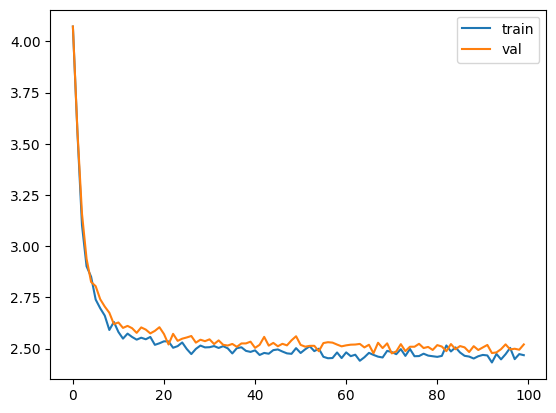

In [ ]:
# Update the MASTER_CONFIG with GPU-related parameters
MASTER_CONFIG.update({
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    'd_model': 128,
    'vocab_size': 65,
    'batch_size': 32,
    'epochs': 1000,
    'log_interval': 10,
})

# Instantiate the SimpleModel_RMS using the updated MASTER_CONFIG
model = SimpleModel_RMS(MASTER_CONFIG)

# Move the model to the GPU
model.to(MASTER_CONFIG['device'])

# Obtain batches for training
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

# Move the data to the GPU
xs, ys = xs.to(MASTER_CONFIG['device']), ys.to(MASTER_CONFIG['device'])

# Calculate logits and loss using the model
logits, loss = model(xs, ys)

# Define the Adam optimizer for model parameters
optimizer = torch.optim.Adam(model.parameters())

# Train the model for 100 epochs
train(model, optimizer)

In [ ]:
def get_rotary_matrix(context_window, embedding_dim):
    # Initialize a tensor for the rotary matrix with zeros
    R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)

    # Loop through each position in the context window
    for position in range(context_window):
        # Loop through each dimension in the embedding
        for i in range(embedding_dim // 2):
            # Calculate the rotation angle (theta) based on the position and embedding dimension
            theta = 10000. ** (-2. * (i - 1) / embedding_dim)
            # Calculate the rotated matrix elements using sine and cosine functions
            m_theta = position * theta
            R[position, 2 * i, 2 * i] = np.cos(m_theta)
            R[position, 2 * i, 2 * i + 1] = -np.sin(m_theta)
            R[position, 2 * i + 1, 2 * i] = np.sin(m_theta)
            R[position, 2 * i + 1, 2 * i + 1] = np.cos(m_theta)
    return R


In [ ]:
class RoPEAttentionHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.w_q = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_k = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_v = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.R = get_rotary_matrix(config['context_window'], config['d_model']).to(config['device'])

    def forward(self, x, return_attn_weights=False):
        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)

        b, m, d = x.shape  # batch size, sequence length, dimension

        q_rotated = (torch.bmm(q.transpose(0, 1), self.R[:m])).transpose(0, 1)
        k_rotated = (torch.bmm(k.transpose(0, 1), self.R[:m])).transpose(0, 1)

        activations = F.scaled_dot_product_attention(
            q_rotated, k_rotated, v, dropout_p=0.1, is_causal=True
        )

        if return_attn_weights:
            attn_mask = torch.tril(torch.ones((m, m)), diagonal=0)
            attn_weights = torch.bmm(q_rotated, k_rotated.transpose(1, 2)) / np.sqrt(d) + attn_mask
            attn_weights = F.softmax(attn_weights, dim=-1)
            return activations, attn_weights

        return activations



In [ ]:
class RoPEMaskedMultiheadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.heads = nn.ModuleList([
            RoPEAttentionHead(config) for _ in range(config['n_heads'])
        ])
        self.linear = nn.Linear(config['n_heads'] * config['d_model'], config['d_model'])
        self.dropout = nn.Dropout(.1)

    def forward(self, x):
        heads = [h(x) for h in self.heads]
        x = torch.cat(heads, dim=-1)
        x = self.linear(x)
        x = self.dropout(x)
        return x


In [ ]:
class RMSNorm(nn.Module):
    def __init__(self, layer_shape, eps=1e-8, bias=False):
        super(RMSNorm, self).__init__()
        self.register_parameter("scale", nn.Parameter(torch.ones(layer_shape)))

    def forward(self, x):
        ff_rms = torch.linalg.norm(x, dim=(1, 2)) * x[0].numel() ** -0.5
        raw = x / ff_rms.unsqueeze(-1).unsqueeze(-1)
        return self.scale[:x.shape[1], :].unsqueeze(0) * raw

In [ ]:
# Update the master configuration with the number of attention heads
MASTER_CONFIG.update({
    'n_heads': 8,
})

In [ ]:
class RopeModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.rms = RMSNorm((config['context_window'], config['d_model']))
        self.rope_attention = RoPEMaskedMultiheadAttention(config)
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
        )
        self.last_linear = nn.Linear(config['d_model'], config['vocab_size'])

        self.device = config['device']  # Added device attribute
        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        x = self.rms(x)
        x = x + self.rope_attention(x)
        x = self.rms(x)
        x = x + self.linear(x)
        logits = self.last_linear(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

model params: 559681
Validation loss:  2.1082448840141295


<Axes: >

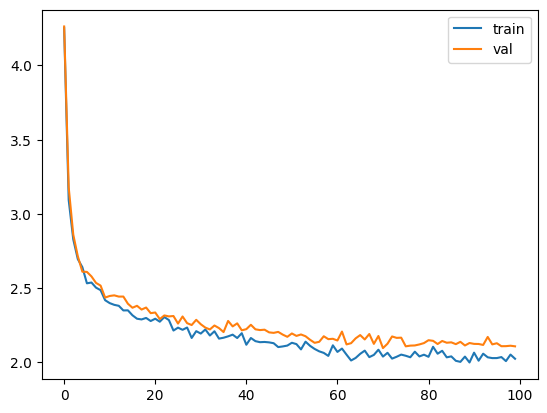

In [ ]:
# Update the MASTER_CONFIG with GPU-related parameters
MASTER_CONFIG.update({
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    'd_model': 128,
    'vocab_size': 65,
    'batch_size': 32,
    'epochs': 1000,
    'log_interval': 10,
    'n_heads': 8,  # Number of attention heads
})

# Instantiate the RopeModel using the updated MASTER_CONFIG
model = RopeModel(MASTER_CONFIG)

# Move the model to the GPU
model.to(MASTER_CONFIG['device'])

# Obtain batches for training
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

# Move the data to the GPU
xs, ys = xs.to(MASTER_CONFIG['device']), ys.to(MASTER_CONFIG['device'])

# Calculate logits and loss using the model
logits, loss = model(xs, ys)

# Define the Adam optimizer for model parameters
optimizer = torch.optim.Adam(model.parameters())

# Train the model for 100 epochs
train(model, optimizer)

In [ ]:
# Updating training configuration with more epochs and a logging interval
MASTER_CONFIG.update({
    'epochs': 5000,
    'log_interval': 10,
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu")
})


In [ ]:
class SwiGLU(nn.Module):
    """ Paper Link -> https://arxiv.org/pdf/2002.05202v1.pdf """
    def __init__(self, size):
        super().__init__()
        #self.config = config  # Configuration information
        self.linear_gate = nn.Linear(size, size)  # Linear transformation for the gating mechanism
        self.linear = nn.Linear(size, size)  # Linear transformation for the main branch
        self.beta = torch.randn(1, requires_grad=True)  # Random initialization of the beta parameter

        # Using nn.Parameter for beta to ensure it's recognized as a learnable parameter
        self.beta = nn.Parameter(torch.ones(1))
        self.register_parameter("beta", self.beta)

    def forward(self, x):
        # Swish-Gated Linear Unit computation
        swish_gate = self.linear_gate(x) * torch.sigmoid(self.beta * self.linear_gate(x))
        out = swish_gate * self.linear(x)  # Element-wise multiplication of the gate and main branch
        return out

In [ ]:
class RopeModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        # Ensure 'device' is in the config and set it as an attribute
        if 'device' not in config:
            raise ValueError("Config must include 'device' key.")
        self.device = config['device']

        # Embedding layer for input tokens
        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])

        # RMSNorm layer for pre-normalization
        self.rms = RMSNorm((config['context_window'], config['d_model']))

        # Multi-head attention layer with RoPE (Rotary Positional Embeddings)
        self.rope_attention = RoPEMaskedMultiheadAttention(config)

        # Linear layer followed by SwiGLU activation
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),  # Adding SwiGLU activation
        )

        # Output linear layer
        self.last_linear = nn.Linear(config['d_model'], config['vocab_size'])

        # Moving the model to the specified device
        self.to(self.device)

        # Printing total model parameters
        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        # Moving input data to the GPU
        x = self.embedding(idx.to(self.config['device']))

        # One block of attention
        x = self.rms(x)  # RMS pre-normalization
        x = x + self.rope_attention(x)

        x = self.rms(x)  # RMS pre-normalization
        x = x + self.linear(x)  # Applying SwiGLU activation

        logits = self.last_linear(x)

        if targets is not None:
            # Moving targets to the specified device
            targets = targets.to(self.config['device'])
            # Calculate cross-entropy loss if targets are provided
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

model params: 592706
Validation loss:  1.9127403616905212


<Axes: >

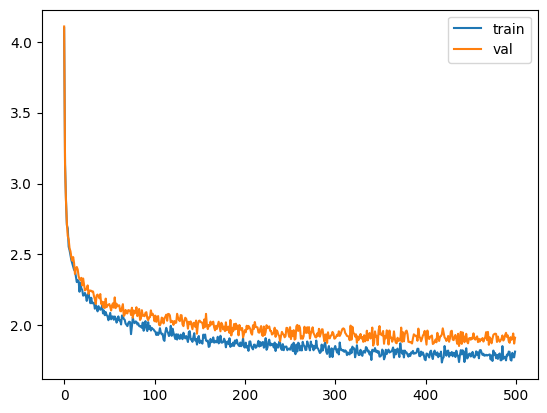

In [ ]:
import torch
import torch.nn as nn

# Create an instance of RopeModel (RMSNorm, RoPE, Multi-Head, SwiGLU)
model = RopeModel(MASTER_CONFIG)

# Obtain batches for training
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

# Calculate logits and loss using the model
logits, loss = model(xs, ys)

# Define the Adam optimizer for model parameters
optimizer = torch.optim.Adam(model.parameters())

# Train the model
train(model, optimizer)

In [ ]:
# Update model configurations for the number of layers
MASTER_CONFIG.update({
    'n_layers': 8,  # Set the number of layers to 4
})

In [ ]:
# add RMSNorm and residual connection
class LlamaBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        # RMSNorm layer
        self.rms = RMSNorm((config['context_window'], config['d_model']))

        # RoPE Masked Multihead Attention layer
        self.attention = RoPEMaskedMultiheadAttention(config)

        # Feedforward layer with SwiGLU activation
        self.feedforward = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
        )

    def forward(self, x):
        # one block of attention
        x = self.rms(x) # RMS pre-normalization
        x = x + self.attention(x)  # residual connection

        x = self.rms(x) # RMS pre-normalization
        x = x + self.feedforward(x)  # residual connection
        return x

In [ ]:
  # Assuming MASTER_CONFIG is defined and includes a 'device' key with a value like 'cuda' or 'cpu'
block = LlamaBlock(MASTER_CONFIG).to(MASTER_CONFIG['device'])

# Generate a random tensor with the specified batch size, context window, and model dimension
# and move it to the same device as the block
random_input = torch.randn(MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], MASTER_CONFIG['d_model'], device=MASTER_CONFIG['device'])

# Apply the LlamaBlock to the random input tensor
output = block(random_input)


In [ ]:
from collections import OrderedDict

class Llama(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        # Embedding layer for token representations
        self.embeddings = nn.Embedding(config['vocab_size'], config['d_model'])

        # Sequential block of LlamaBlocks based on the specified number of layers
        self.llama_blocks = nn.Sequential(
            OrderedDict([(f"llama_{i}", LlamaBlock(config)) for i in range(config['n_layers'])])
        )

        # Feedforward network (FFN) for final output
        self.ffn = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        # Move the model to the appropriate device
        self.device = config['device']
        self.to(self.device)

        # Print total number of parameters in the model
        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        # Input token indices are passed through the embedding layer
        x = self.embeddings(idx.to(self.device))

        # Process the input through the LlamaBlocks
        x = self.llama_blocks(x)

        # Pass the processed input through the final FFN for output logits
        logits = self.ffn(x)

        # If targets are not provided, return only the logits
        if targets is None:
            return logits
        # If targets are provided, compute and return the cross-entropy loss
        else:
            # Move targets to the specified device
            targets = targets.to(self.device)

            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

model params: 141445706
Validation loss:  3.3278706073760986


<Axes: >

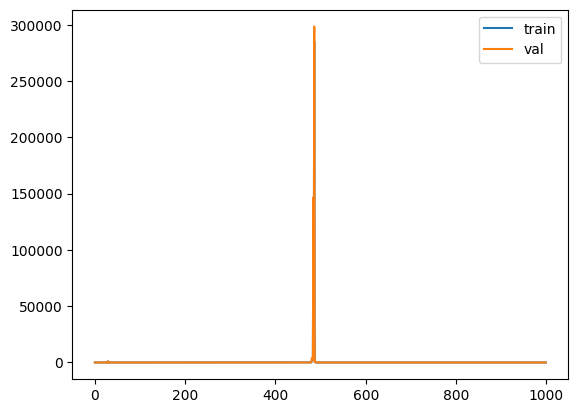

In [ ]:
# Create an instance of Llama (RMSNorm, RoPE, Multi-Head, SwiGLU, N_layers)
llama = Llama(MASTER_CONFIG)

# Obtain batches for training
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

# Calculate logits and loss using the model
logits, loss = llama(xs, ys)

# Define the Adam optimizer for model parameters
optimizer = torch.optim.Adam(llama.parameters())

# Train the model
train(llama, optimizer)

In [ ]:
# Update the number of epochs in the configuration
MASTER_CONFIG.update({
    'epochs': 10000,
    'd_model':512,
    'n_heads':16,
    'n_layers':8,
    'dropout':0.1,
})
# Train the LLaMA model for the specified number of epochs
train(llama, optimizer, scheduler=None, config=MASTER_CONFIG)

KeyboardInterrupt: 

Validation loss:  0.9794728338718415


<Axes: >

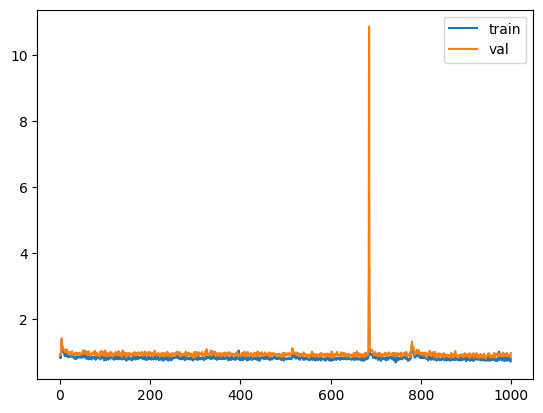

In [ ]:
# Training the model again, scheduler for better optimization.
train(llama, optimizer, config=MASTER_CONFIG)

In [ ]:
# prompt: print the MASTER_CONFIG

print(MASTER_CONFIG)


{'batch_size': 32, 'context_window': 16, 'device': device(type='cuda'), 'd_model': 512, 'vocab_size': 65, 'epochs': 10000, 'log_interval': 10, 'n_heads': 16, 'n_layers': 8}


In [ ]:
# Print the model parameters
for name, param in llama.named_parameters():
    print(f"{name}: {param.numel()} parameters")


embeddings.weight: 8320 parameters
llama_blocks.llama_0.rms.scale: 2048 parameters
llama_blocks.llama_0.attention.heads.0.w_q.weight: 16384 parameters
llama_blocks.llama_0.attention.heads.0.w_k.weight: 16384 parameters
llama_blocks.llama_0.attention.heads.0.w_v.weight: 16384 parameters
llama_blocks.llama_0.attention.heads.1.w_q.weight: 16384 parameters
llama_blocks.llama_0.attention.heads.1.w_k.weight: 16384 parameters
llama_blocks.llama_0.attention.heads.1.w_v.weight: 16384 parameters
llama_blocks.llama_0.attention.heads.2.w_q.weight: 16384 parameters
llama_blocks.llama_0.attention.heads.2.w_k.weight: 16384 parameters
llama_blocks.llama_0.attention.heads.2.w_v.weight: 16384 parameters
llama_blocks.llama_0.attention.heads.3.w_q.weight: 16384 parameters
llama_blocks.llama_0.attention.heads.3.w_k.weight: 16384 parameters
llama_blocks.llama_0.attention.heads.3.w_v.weight: 16384 parameters
llama_blocks.llama_0.attention.heads.4.w_q.weight: 16384 parameters
llama_blocks.llama_0.attention.he

In [ ]:
# Generate text using the trained LLM (llama) with a maximum of 500 tokens
generated_text = generate(llama, MASTER_CONFIG, 500)[0]
print(generated_text)


y
cyaeiva tNa;FiaeAnvOoeiwt  lstdw
ni
llo'dwenOfe ':irot htYsis . eo
ahfc &wptreSheE .h  
g veteeefmlEmmibna hiKeN i Js  uo
M$ lnqUu o oEI:etnhN
ehotm' etd y s .

e  t ntsyEnal; e

&ddv  s!mEuG slyelcesese issDd i,Stie ekms rUaytmn hrh aanr D,hsm rh aIrn:&issannGaolcmeumeee ldtofeoldhvte mokssldmth
itllvest i
rfontGtit dessr
ua tj feIhmh'eol lgnkyhB  weosi .etu  m knie rprf n$:w  .hdH 
ntend?vorLc ro dt lrtatillh.Whus  'aib nh cSdtr tsuhu
MmdeB m?n Twea?S sph npn OA
edaed s
eO  h  o,e gLawr;iztm


In [ ]:
# Get batches from the test set
xs, ys = get_batches(dataset, 'test', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

# Pass the test data through the LLaMA model
logits, loss = llama(xs, ys)

# Print the loss on the test set
print(loss)

tensor(3.3738, device='cuda:0', grad_fn=<NllLossBackward0>)


model params: 141445706


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:809: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


lr:  [0.0009999457184159408]
lr:  [0.0009961510274583004]
lr:  [0.0009869757772816292]
lr:  [0.0009725204933511963]
lr:  [0.0009529435502760634]
lr:  [0.0009284594366176498]
lr:  [0.0008993364049014041]
lr:  [0.0008658935325782156]
lr:  [0.0008284972261358946]
lr:  [0.0007875572066618724]
lr:  [0.0007435220208394261]
lr:  [0.0006968741265588948]
lr:  [0.0006481246069855613]
lr:  [0.0005978075709959357]
lr:  [0.0005464743013294258]
lr:  [0.0004946872145648923]
lr:  [0.00044301369909075325]
lr:  [0.00039201989856974814]
lr:  [0.0003422645089892466]
lr:  [0.0002942926572257539]
lr:  [0.0002486299281339155]
lr:  [0.0002057766054928797]
lr:  [0.00016620218969383484]
lr:  [0.00013034025177986015]
lr:  [9.85836791664324e-05]
lr:  [7.128036241775617e-05]
lr:  [4.872936226262451e-05]
lr:  [3.117756953567661e-05]
lr:  [1.8816750064937722e-05]
lr:  [1.1779739336260682e-05]
lr:  [1.0054282328142978e-05]
lr:  [1.396862020283371e-05]
lr:  [2.3138198807489664e-05]
lr:  [3.7591595433673565e-05]
lr:  [

<Axes: >

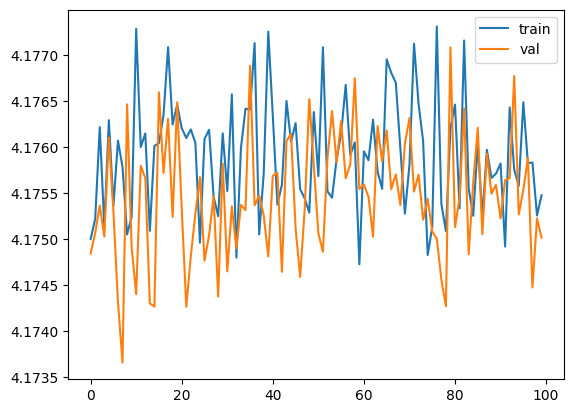

In [ ]:
# Update configuration
MASTER_CONFIG.update({
    "epochs": 1000
})

# Create Llama model with Cosine Annealing learning schedule
llama_with_cosine = Llama(MASTER_CONFIG)

# Define Adam optimizer with specific hyperparameters
llama_optimizer = torch.optim.Adam(
    llama.parameters(),
    betas=(.9, .95),
    weight_decay=.1,
    eps=1e-9,
    lr=1e-3
)

# Define Cosine Annealing learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(llama_optimizer, 300, eta_min=1e-5)

# Train the Llama model with the specified optimizer and scheduler
train(llama_with_cosine, llama_optimizer, scheduler=scheduler)

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
# List files in the root directory of your Google Drive
!ls '/content/gdrive/My Drive/'


'001 (2).jpg'
 1681400532950689854676385822517.jpg
 16814006185704842560102000398598.jpg
'21BRS1552 EXP-1.docx'
'21BRS1552 EXP-1.gdoc'
'21BRS1552 EXP 2.gdoc'
'21BRS1552 EXP-3.gdoc'
 2445675903.pdf
'300+ Scholarships List.gsheet'
'310_Case Study 2 -Air Quality monitoring using ESP32-WROOM-32D with Analog Sensor and Thingspeak Cloud Computing.gslides'
 Adobe_Express_20221002_2055220_1.png
 Adobe_Express_20230604_1312330_1.png
 Adobe_Express_20230604_1312380_1.png
'aggisnment 2 kanishk kumar sachan 21BRS1552.gdoc'
'Air quality index monitoring system .gdoc'
'Assignment 4 - 21BRS1477 (1).docx'
'ASSIGNMENT – 7 .gdoc'
 Aysha_OpEd_UNSC.gdoc
 banknifty_data.gsheet
'bhavi assignment'
 BMAT205L_DISCRETE-MATHEMATICS-AND-GRAPH-THEORY_TH_1.0_67_BMAT205L.pdf
 Classroom
'Colab Notebooks'
'Computer Networks Lab 9 (1).docx'
'Computer Networks Lab 9.docx'
'DA-1 1552.gdoc'
'DA-1 1552.pdf'
'da1 assignment link.txt'
'da 2 assigment.gdoc'
'da 2 assigment.pdf'
 dataset.gsheet
'DBMS (1).txt'
'Decoding the UNC

In [ ]:
+# Save the entire model to Google Drive
torch.save(llama, '/content/gdrive/My Drive/llama_model1.pth')

# Save only the model parameters to Google Drive
torch.save(llama.state_dict(), '/content/gdrive/My Drive/llama_model_params1.pth')


In [ ]:
# Generate text using the trained LLM (llama) with a maximum of 500 tokens
generated_text = generate(llama, MASTER_CONFIG, 500)[0]
print(generated_text)


 I soun in would noiters come may I to will seet that death speak our witTle
Of if Be linghiness the graves criot
Day forth the mantale is trumed it and oughtious diubed which fasp Come wright's.

Nurdch Backronge buthers
To the yeeplied of yie,
My it their came eade,
How our retray sade,
In soul, war wers, when sace the rague's rist me, gentlumber Bigory hate
Exbe on agion.
Mane goe; the butch'd claud they since my Glotious letted
And with heart him thus, more morath! I say is Migarge.
For oure
